# Load packages:

In [1]:
!python -V

Python 3.12.10


In [2]:
import os
os.chdir('..') # Para subir um nível do diretório 'notebooks'
print(os.getcwd()) # Confirme que agora é a raiz do projeto

/home/jovyan/work


In [3]:
from src.read_dataframe import read_dataframe
from src.compute_duration import compute_duration
from src.cast_metrics import cast_metrics
from src.drop_outliers import drop_outliers
from src.select_metrics import select_metrics

In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

# Q1 - Downloading the data:

In [8]:
jan_data = read_dataframe('data/yellow_tripdata_2023-01.parquet')
feb_data = read_dataframe('data/yellow_tripdata_2023-02.parquet')

In [9]:
jan_data.shape

(3066766, 19)

In [10]:
jan_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


# Q2 - Computing duration:

In [11]:
jan_data = compute_duration(jan_data)
feb_data = compute_duration(feb_data)

In [12]:
jan_data['duration'].std()

42.594351241920904

# Q3 - Dropping outliers:

In [13]:
jan_data_without_outliers = drop_outliers(jan_data)
feb_data_without_outliers = drop_outliers(feb_data)

In [14]:
jan_data_without_outliers.shape[0] / jan_data.shape[0] * 100

98.1220282212598

In [15]:
feb_data_without_outliers.shape[0] / feb_data.shape[0] * 100


98.00944077722545

In [18]:
from sklearn.model_selection import train_test_split

# Assuming 'column_name' is the column you want to stratify by
_, jan_data_without_outliers = train_test_split(jan_data_without_outliers,
                                                    test_size=0.2,
                                                    stratify=jan_data_without_outliers['duration'],
                                                    random_state=42)
_, feb_data_without_outliers = train_test_split(feb_data_without_outliers,
                                                     test_size=0.2,
                                                     stratify=feb_data_without_outliers['duration'],
                                                     random_state=42)

# Q4 - One-hot encoding:

In [19]:
jan_data_without_outliers = cast_metrics(jan_data_without_outliers)
feb_data_without_outliers = cast_metrics(feb_data_without_outliers)

In [20]:
train_df = select_metrics(jan_data_without_outliers)
test_df = select_metrics(feb_data_without_outliers)

In [21]:
# Apply one hot encoding
vec = DictVectorizer()
train_dicts = train_df.to_dict(orient='records')
test_dicts = test_df.to_dict(orient='records')

X_train = vec.fit_transform(train_dicts).toarray()

In [22]:
X_test = vec.transform(test_dicts).toarray()

In [23]:
X_train.shape

(601835, 504)

In [25]:
y_train = jan_data_without_outliers['duration']
y_test = feb_data_without_outliers['duration']

# Q5 - Training a model:

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
y_pred = lr.predict(X_train)

In [32]:
y_pred[y_pred < 1] = 1
y_pred[y_pred > 60] = 60

In [33]:
root_mean_squared_error(y_train, y_pred)

7.643529195113847

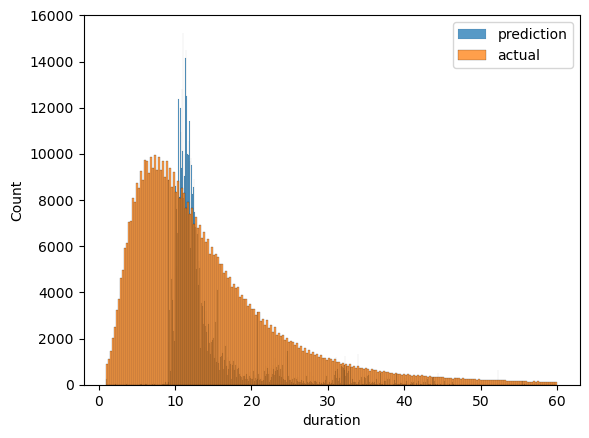

In [34]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

# Q6 - Evaluating the model:

In [44]:
y_test_pred = lr.predict(X_test)

In [45]:
y_test_pred[y_test_pred < 1] = 1
y_test_pred[y_test_pred > 60] = 60

In [47]:
root_mean_squared_error(y_test.values, y_test_pred)

7.813406484686155

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

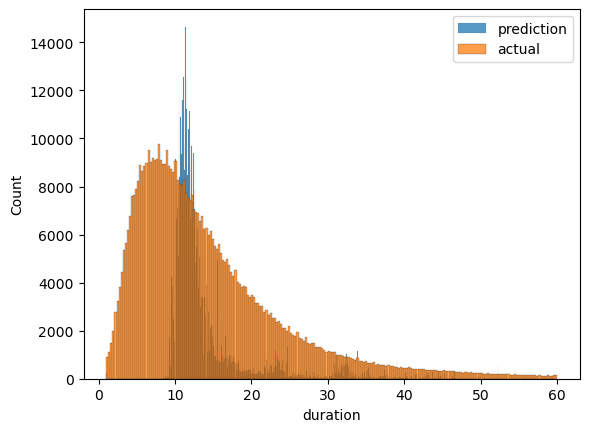

In [48]:
sns.histplot(y_test_pred, label='prediction')
sns.histplot(y_test, label='actual')

plt.legend()